epoch 1
train mean loss=1.5071866964488887
 test mean loss=0.11959863026936848
epoch 2
train mean loss=1.370595299536708
 test mean loss=0.11469928741455078
epoch 3
train mean loss=1.3219431685924332
 test mean loss=0.11784309387207031
epoch 4
train mean loss=1.2622909311355774
 test mean loss=0.10559055964152018
epoch 5
train mean loss=1.2148028962460098
 test mean loss=0.10433828989664713
epoch 6
train mean loss=1.1798401232707894
 test mean loss=0.10299289067586263
epoch 7
train mean loss=1.1384093712746675
 test mean loss=0.10045415878295899
epoch 8
train mean loss=1.1176157446889492
 test mean loss=0.10215657552083333
epoch 9
train mean loss=1.1356760075113186
 test mean loss=0.10026038487752278
epoch 10
train mean loss=1.097788882484134
 test mean loss=0.10297562917073567
epoch 11
train mean loss=1.1169698952932863
 test mean loss=0.0961411476135254
epoch 12
train mean loss=1.088321726339069
 test mean loss=0.101228453318278
epoch 13
train mean loss=1.059320745591374
 test mean l

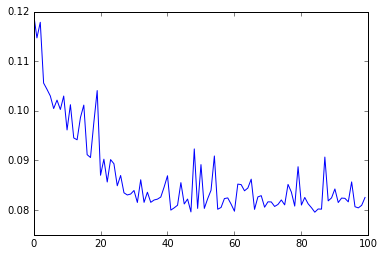

In [1]:
#数量はここ！！

#!/usr/bin/env python
# coding: utf-8
import pandas as pd
temp=pd.read_csv("features.csv",names=('ShopID','Square','ShopType','ShopRank','Category','PS'))
temptarget = pd.read_csv("sales.csv",header=0)

#コメント
#from __future__ import print_function
import numpy as np
from sklearn.cross_validation import train_test_split

import six
import sys
import chainer
import chainer.links as L
from chainer import optimizers
import chainer.functions as F
from matplotlib import pyplot
%matplotlib inline


batchsize = 40
n_epoch = 100

# Prepare dataset
target_list=[]
for i in zip(temptarget['Quant']):
    target_list.append([i])
target = np.array(target_list)


feature_lists = []
#for i,j,k,l in zip(temp['ShopID'],temp['Square'],temp['ShopRank'],temp['ShopType'],temp['PS']):
for i,j,k,l in zip(temp['Square'],temp['ShopType'],temp['ShopRank'],temp['PS']):
    feature_lists.append([i,j,k,l])
features = np.array(feature_lists)

target=target.astype(np.float32).reshape(len(target_list), 1)
feature=features.astype(np.float32)


x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.2)
N_test = y_test.size  # test data size
N = len(x_train)  # train data size
in_units = x_train.shape[1]  


n_units_2 = 90
n_units_3 = 90
n_units_4 = 90
n_units_5 = 10

model = chainer.Chain(
    l1=L.Linear(in_units, n_units_2),
    l2=L.Linear(n_units_2, n_units_3),
    l3=L.Linear(n_units_3,  n_units_4),
    l4=L.Linear(n_units_4,  n_units_5),
    l5=L.Linear(n_units_5,  1))


def forward(x):
    h1 = F.relu(model.l1(x))
    h2 = F.relu(model.l2(h1))
    h3 = F.relu(model.l3(h2))
    h4 = F.relu(model.l4(h3))
    y = model.l5(h4)
    return y
    #return F.tanh(model.l5(h4))

# Setup optimizer最適化のセットアップ
optimizer = optimizers.Adam()#勾配法のアルゴリズム:Adam
optimizer.setup(model)
#optimizer.add_hokk(optimizer.WeightDecay())#正則化をhook関数として登録

# Learning loop
LOSS = []
Ylist = []
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    # training
    perm = np.random.permutation(N)
    sum_loss = 0.0
    for i in six.moves.range(0, N, batchsize):
        x = chainer.Variable(np.asarray(x_train[perm[i:i + batchsize]]))
        t = chainer.Variable(np.asarray((y_train[perm[i:i + batchsize]])))
        model.zerograds()#勾配をゼロ初期化
        y = forward(x)
        loss = F.mean_squared_error(y, t)#平均2乗誤差
        sum_loss += loss.data
        loss.backward()#勾配計算
        optimizer.update()#最適化ルーチンを実行
    print('train mean loss={}'.format(sum_loss / N))

    # all test data
    x = chainer.Variable(np.asarray(x_test))#特徴量
    t = chainer.Variable(np.asarray((y_test)))#教師データ
    y = forward(x)#出力
    loss = F.mean_squared_error(y, t)
    LOSS.append(loss.data/N_test)
    print(' test mean loss={}'.format(loss.data / N_test))
Ylist.append(y.data)
#print("Y = ", Ylist)
pyplot.plot((LOSS))

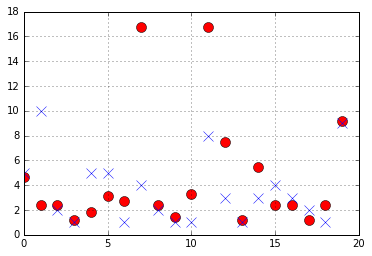

In [2]:
#パワポ用に結果画面出すためのコードです
pyplot.plot(Ylist[0][0:20],"ro",markersize=10)
pyplot.plot(y_test[0:20],"bx",markersize=10)
pyplot.ylim=30
pyplot.grid()

#以下、結果のメモです
#train mean loss=1.2835919822241277
#test mean loss=0.08556671778361002
#epoch40
#train mean loss=1.0556385772533345
#test mean loss=0.06668860117594401

#n_units_2 = 90
#n_units_3 = 70
#n_units_4 = 30
#n_units_5 = 10
#batchsize = 40
#n_epoch = 100
#epoch 100
#train mean loss=1.01585703345327
#test mean loss=0.05284663200378418

#n_units_2 = 90
#n_units_3 = 90
#n_units_4 = 90
#n_units_5 = 10
#epoch 100
#train mean loss=1.0171331057403425
#test mean loss=0.05391091028849284

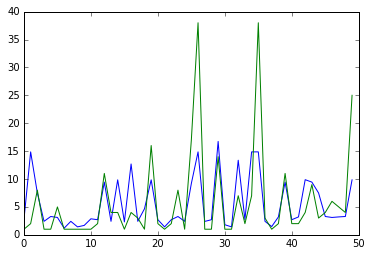

In [3]:
#パワポ用に結果画面出すためのコードです
pyplot.plot(Ylist[0][50:100])#出力(青)
pyplot.plot(y_test[50:100])#正解データ(緑)
pyplot.ylim=30
#train mean loss=1.0372128349485472
#test mean loss=0.0751815668741862

In [4]:
#MAPE算出
MAPE= (abs((Ylist[0]-y_test)/y_test))*(1/365)*100
for i in MAPE:
    sum =+ i
print(sum)

[ 0.01346272]


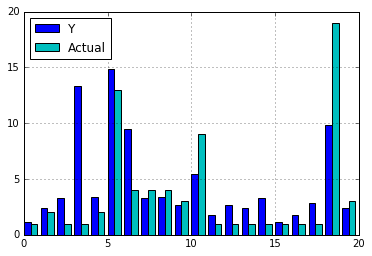

In [5]:
#パワポ用に結果画面出すためのコードです
# -*- coding: utf-8 -*-
import numpy as np
w=0.4
Y1=np.array(Ylist[0][100:120])
Y2=np.array(y_test[100:120])
X=np.arange(len(Y1))

pyplot.bar(X,Y1,color='b',width=w,label="Y")
pyplot.bar(X+w,Y2,color='c',width=w,label="Actual")
pyplot.legend(loc="best")
pyplot.grid()
pyplot.xlim=(0,20)
pyplot.show()

[平均誤差= 3.72894 誤差分散= 35.6125 ]


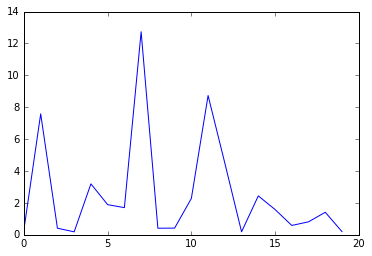

In [6]:
diff=[]
diff.append(abs(Ylist[0]-y_test))
pyplot.plot(diff[0][0:20])
print("[平均誤差=",np.mean(diff[0]),"誤差分散=",np.var(diff[0]),"]")
#print(diff[0])
pyplot.title=("Y-Actual")
pyplot.show()

In [8]:
np.max(np.abs(diff))

46.706139